In [1]:
# new all 

In [127]:
# noise vocoded speech

# 噪音
from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio
import librosa
plt.style.use('bmh')
%matplotlib inline


In [128]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])
from scipy.signal import lfilter

def design_filter(bounds, fs):
    return sp.signal.butter(4, bounds * 2 / fs, btype='bandpass')

def octave_spaced_frequencies(low, high):
    number_of_octaves = np.log2(high) - np.log2(low)
    return low * 2 ** arange(number_of_octaves)
def design_filterbank(center_frequencies, fs):
    boundaries = [third_octave_bounds(cf) for cf in center_frequencies]
    return [design_filter(bounds, fs) for bounds in boundaries]
def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = design_filterbank(center_frequencies, fs)
    y = zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

# 提取低频震荡的 两种手法 应该是 
# 1 20hz的低筒滤波
# 2 那个技术的 

In [129]:
# (7, 39629)
def reshape(duration,signal):  
    duration = duration
    #ms
    sample_points = int(duration/1000*fs)

    to_pad = round(len(x)/sample_points) * sample_points

    length = abs(len(x) - to_pad)

    x_padded = np.pad(signal, ((0, 0), (0, length)),constant_values=(0, 0))
    
    x_seg = x_padded.reshape(7, round(len(x)/sample_points),sample_points)
    
    return x_seg, x_padded, to_pad

def normalized_all(filtered_s):
    plane_all = np.zeros((7, filtered_s.shape[-1]*filtered_s.shape[-2]))
    temp = filtered_s
    for i in range(temp.shape[0]):
        x_signal = temp[i]
        #
        plane = np.zeros((filtered_s.shape[-2], filtered_s.shape[-1]))
        for j in range(x_signal.shape[0]):
            tp = [(x_signal[j].mean()) for i in x_signal[j]]
            plane[j] = tp
            mean_s = plane.flatten()
        plane_all[i] = mean_s
    return plane_all

def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    n_samples = x.shape[-1]
    noise = np.random.randn(n_samples) 

    filtered_x = apply_filterbank(x, center_frequencies, fs)
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    vocoded_noise = np.zeros((n_channels, n_samples))
    for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
    return np.sum(vocoded_noise, axis=0)


In [130]:
fs, x = wavfile.read('552.wav')

x = x.astype('float')

print('sampling frequency is {} {}'.format(x.shape,fs))


# fs, cheese = wavfile.read('long3.wav')
# x = cheese.astype('float')

# print('sampling frequency is {}'.format(fs))

sampling frequency is (225173,) 16000


In [131]:
# work one 

center_frequencies = octave_spaced_frequencies(100, 7000)

n_channels = len(center_frequencies)
# 几个滤波器 
n_samples = x.shape[-1]
# 获取sample的数量
noise = np.random.randn(n_samples) 
# 生成白噪音 

filtered_x = apply_filterbank(x, center_frequencies, fs)
filtered_noise = apply_filterbank(noise, center_frequencies, fs)


# 获取 noise plant
envelope_all = np.zeros((n_channels, n_samples))
for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
    
    envelope = extract_envelope(x_band)
    # reshape & normalization 
    envelope_all[idx] = envelope
    
filtered_x_seg,filtered_x_all, leg = reshape(40,envelope_all)

norm_x = normalized_all(filtered_x_seg)

filtered_noise_seg,filtered_noise_all, leg = reshape(40,filtered_noise)

vocoded_noise = np.zeros((n_channels, leg))

# 分段 获取 padding 后的长度 噪音应该不能 normalization 我觉得 
# filtered_noise_seg,leg = reshape(40,filtered_noise)
# norm_noise = normalized_all(filtered_noise_seg)

for idx, (x_band, noise_band) in enumerate(zip(norm_x, filtered_noise_all)):
    # x_band = 归一化后的 包络
    # noise 归一化后的 噪音
    vocoded_noise[idx] = x_band * noise_band

In [8]:
#center_frequencies = octave_spaced_frequencies(100, 6000)
#vocoded_cheese = vocode(cheese, center_frequencies, fs)
#print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
#Audio(vocoded_cheese, rate=fs)

In [9]:
final = np.sum(vocoded_noise,axis = 0)

In [10]:
Audio(x, rate=fs)

In [11]:
Audio(final, rate=fs)

In [12]:
Audio(vocoded_cheese, rate=fs)

NameError: name 'vocoded_cheese' is not defined

In [186]:
def compare_spectrogram(x, y,fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(16, 8))

    p_x, *_, im  = axes[0].specgram(x, cmap='Greys', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='Greys', Fs=fs, vmin=vmin, vmax=vmax)
    #_ = axes[2].specgram(vocoded_cheese, cmap='Greys', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Mosaic Modified')
    #axes[2].set_title('NV Modified')
    for ax in axes:
        #ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    #cbar = fig.colorbar(im)
    #cbar.ax.set_ylabel('Magnitude (dB)')
    #fig.tight_layout()
    fig.savefig('ddc.svg')

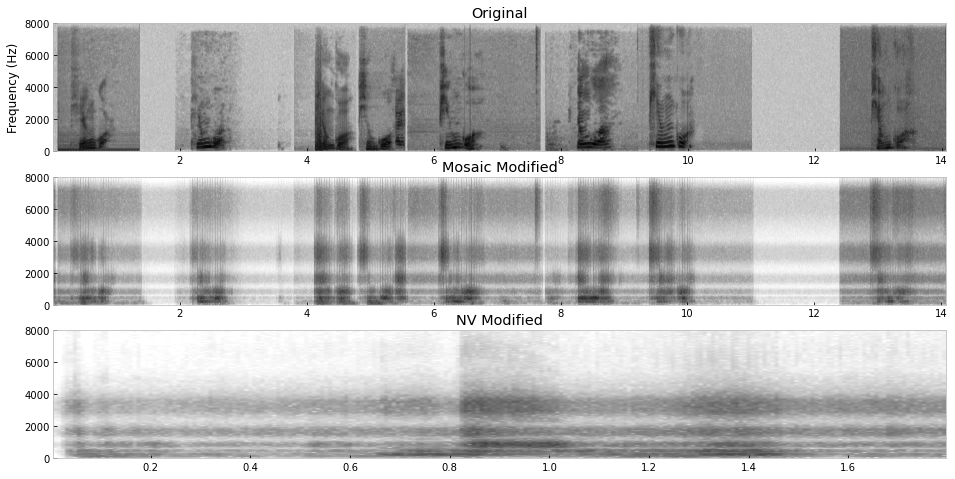

In [264]:
compare_spectrogram(x,final,vocoded_cheese,fs)

Text(0.5, 1.0, 'Monophonic')

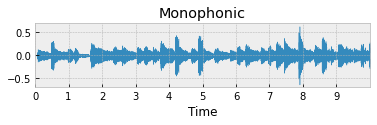

In [137]:
import matplotlib.pyplot as plt
y, sr = librosa.load(librosa.util.example_audio_file(), duration=10)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')


In [211]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.signal import butter, lfilter
import librosa, librosa.display
from scipy.signal import hilbert, chirp
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import glob
from brian2 import *
from brian2hears import *
from tqdm.notebook import tqdm
%matplotlib inline


In [212]:
def reshape(n_channel, duration,signal):  
    duration = duration
    #ms
    sample_points = int(duration/1000*fs)

    to_pad = round(len(x)/sample_points) * sample_points

    length = abs(len(x) - to_pad)

    x_padded = np.pad(signal, ((0, 0), (0, length)),constant_values=(0, 0))
    
    x_seg = x_padded.reshape(n_channel, round(len(x)/sample_points),sample_points)
    
    return x_seg, x_padded, to_pad

def normalized_all(n_channel,filtered_s):
    plane_all = np.zeros((n_channel, filtered_s.shape[-1]*filtered_s.shape[-2]))
    temp = filtered_s
    for i in range(temp.shape[0]):
        x_signal = temp[i]
        #
        plane = np.zeros((filtered_s.shape[-2], filtered_s.shape[-1]))
        for j in range(x_signal.shape[0]):
            tp = [(x_signal[j].mean()) for i in x_signal[j]]
            plane[j] = tp
            mean_s = plane.flatten()
        plane_all[i] = mean_s
    return plane_all

In [213]:
file = 'mang3.wav'  ## demo _ jp.wav

x,fs = librosa.load(file,sr=16000)

sound = loadsound(file)
#x, index = librosa.effects.trim(sound,top_db= 20)
cf = erbspace(0*Hz,8*kHz, 20)
b1 = 1.019


n_channels = len(cf)
# 几个滤波器 
n_samples = x.shape[-1]
# 获取sample的数量
noise = np.random.randn(n_samples) 

noise_2_filter = Sound(noise, samplerate=16*kHz)

gammatone = Gammatone(sound, cf, b=b1)
gt_mon = gammatone.process()

gammatone_noise = Gammatone(noise_2_filter, cf, b=b1)
gt_noise = gammatone.process()

# 滤波已经做完啦。

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]


In [214]:

# 生成白噪音 

filtered_x = gt_mon.transpose()
filtered_noise = gt_noise.transpose()


# 获取 noise plant
envelope_all = np.zeros((n_channels, n_samples))



In [215]:
for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
    envelope = extract_envelope(x_band)
    # reshape & normalization 
    envelope_all[idx] = envelope
    
    
    
filtered_x_seg,filtered_x_all, leg = reshape(20, 40,envelope_all)

norm_x = normalized_all(20,filtered_x_seg)

filtered_noise_seg,filtered_noise_all, leg = reshape(20, 40,filtered_noise)

vocoded_noise = np.zeros((n_channels, leg))


plt.plot(envelope_all[3]) # 包络ok


In [216]:
for idx, (x_band, noise_band) in enumerate(zip(norm_x, filtered_noise_all)):
    # x_band = 归一化后的 包络
    # noise 归一化后的 噪音
    vocoded_noise[idx] = x_band * noise_band

In [217]:
final = np.sum(vocoded_noise,axis = 0)
Audio(final,rate = fs)

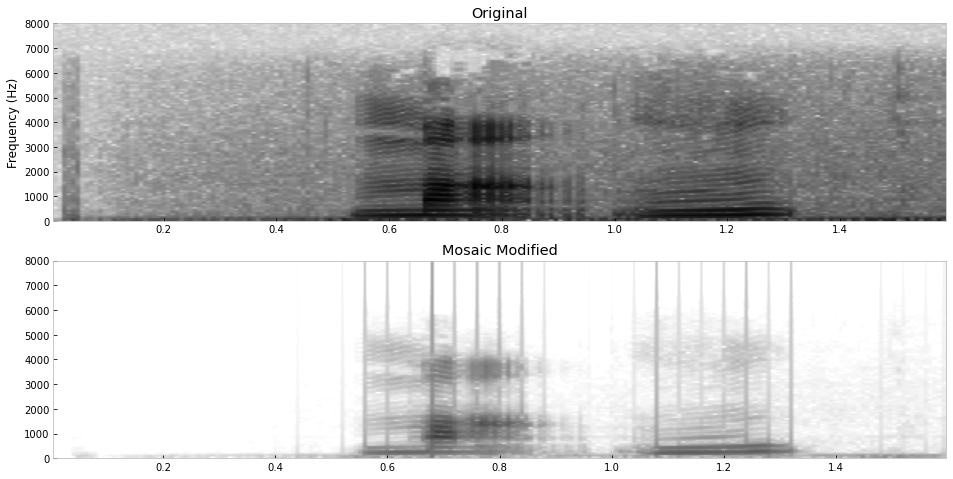

In [218]:
compare_spectrogram(x,final,fs)